In [1]:
# General imports
from pathlib import Path
from dataclasses import dataclass
from typing import Optional, Iterable, Any
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["figure.figsize"] = (18, 10)
plt.rcParams["figure.facecolor"] = "white"

# ML imports
import torch
from torch.utils import data
from torch import nn
import torch.nn.functional as F

# power_perceiver imports
from power_perceiver.dataset import NowcastingDataset
from power_perceiver.consts import BatchKey
from power_perceiver.data_loader import HRVSatellite, PV, Sun
from power_perceiver.xr_batch_processor import SelectPVSystemsNearCenterOfImage, ReduceNumPVSystems, ReduceNumTimesteps
from power_perceiver.np_batch_processor import EncodeSpaceTime
from power_perceiver.transforms.satellite import PatchSatellite
from power_perceiver.transforms.pv import PVPowerRollingWindow

/home/jack/miniconda3/envs/power_perceiver/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_PATH = Path("~/dev/ocf/power_perceiver/data_for_testing/").expanduser()

def get_dataloader(data_path: Path, tag: str) -> data.DataLoader:
    assert tag in ["train", "validation"]
    assert data_path.exists()
    
    xr_batch_processors = [
        SelectPVSystemsNearCenterOfImage(),
        ReduceNumPVSystems(requested_num_pv_systems=8),
        ]
    
    if tag == "train":
        xr_batch_processors.append(ReduceNumTimesteps(requested_timesteps=4))
    
    dataset = NowcastingDataset(
        data_path=data_path,
        data_loaders=[
            HRVSatellite(
                transforms=[PatchSatellite()]
                ), 
            PV(
                transforms=[PVPowerRollingWindow()]
                ),
        ],
        xr_batch_processors=xr_batch_processors,
        np_batch_processors=[EncodeSpaceTime()]
    )

    dataloader = data.DataLoader(
        dataset,
        batch_size=None,
        num_workers=1,
        pin_memory=False,
    )
    
    return dataloader

train_dataloader = get_dataloader(DATA_PATH, tag="train")

In [3]:
for np_batch in train_dataloader:
    break

In [4]:
from power_perceiver.np_batch_processor import Topography

In [7]:
topography = Topography("/home/jack/europe_dem_2km_osgb.tif")

/home/jack/miniconda3/envs/power_perceiver/lib/python3.9/site-packages/pyresample/image.py:59: FutureWarning: Usage of ImageContainer is deprecated, please use NumpyResamplerBilinear class instead
  warnings.warn(
/home/jack/miniconda3/envs/power_perceiver/lib/python3.9/site-packages/pyproj/crs/crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
/home/jack/miniconda3/envs/power_perceiver/lib/python3.9/site-packages/pyproj/crs/crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
/home/jack/miniconda3/envs/power_perceiver/lib/python3.9/site-pack

In [8]:
%%time
np_batch = topography(np_batch)

CPU times: user 177 ms, sys: 33 µs, total: 177 ms
Wall time: 175 ms


In [9]:
np_batch[BatchKey.hrvsatellite].shape

torch.Size([31, 4, 1, 16, 16, 16])

In [10]:
np_batch.keys()

dict_keys([<BatchKey.hrvsatellite: 1>, <BatchKey.hrvsatellite_time_utc: 6>, <BatchKey.hrvsatellite_y_osgb: 2>, <BatchKey.hrvsatellite_x_osgb: 3>, <BatchKey.hrvsatellite_y_geostationary: 4>, <BatchKey.hrvsatellite_x_geostationary: 5>, <BatchKey.pv: 11>, <BatchKey.pv_system_row_number: 12>, <BatchKey.pv_id: 13>, <BatchKey.pv_capacity_wp: 14>, <BatchKey.pv_mask: 15>, <BatchKey.pv_time_utc: 18>, <BatchKey.pv_x_osgb: 17>, <BatchKey.pv_y_osgb: 16>, <BatchKey.hrvsatellite_x_osgb_fourier: 9>, <BatchKey.pv_x_osgb_fourier: 21>, <BatchKey.hrvsatellite_y_osgb_fourier: 8>, <BatchKey.pv_y_osgb_fourier: 20>, <BatchKey.hrvsatellite_time_utc_fourier: 10>, <BatchKey.pv_time_utc_fourier: 22>, <BatchKey.hrvsatellite_surface_height: 7>])

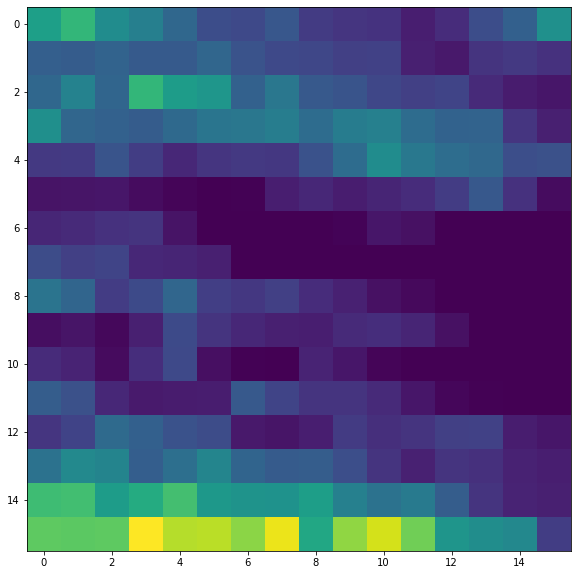

In [38]:
EXAMPLE_IDX = 9
plt.imshow(np_batch[BatchKey.hrvsatellite_surface_height][EXAMPLE_IDX])

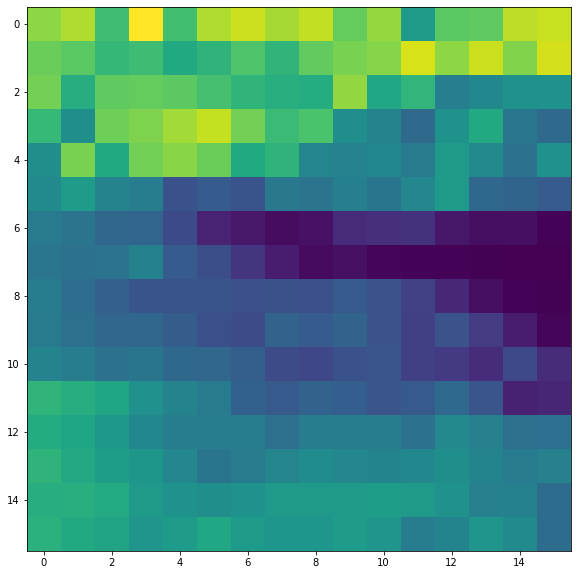

In [39]:
plt.imshow(np_batch[BatchKey.hrvsatellite][EXAMPLE_IDX, 0, 0].mean(-1))